In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc("axes",labelsize = 14)
mpl.rc("xtick", labelsize = 12)
mpl.rc("ytick",labelsize = 12)
import os


In [73]:
### Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [17]:
def plot_image(image):
    plt.imshow(image, cmap = "gray",interpolation = "nearest")
    plt.axis("off")
def plot_color_image(image):
    plt.imshow(image,interpolation = "nearest")
    plt.axis("off")
    

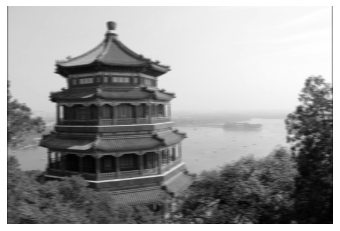

In [18]:
import numpy as np 
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")/255
flower = load_sample_image("flower.jpg")/255
images = np.array([china,flower])
batch_size, height, width, channels = images.shape

#create 2 filters
filters= np.zeros(shape = (7,7,channels,2), dtype = np.float32)
filters[:,3,:,0] = 1 #vertical lines
filters[3,:,:,1] = 1 #horizontal lines
outputs = tf.nn.conv2d(images,filters,strides= 1,padding = "SAME")
plt.imshow(outputs[0,:,:,1],cmap = "gray")
plt.axis("off")
plt.show()

In [76]:
images.shape#(batch,height,width,channel)

(2, 427, 640, 3)

In [77]:
filters.shape #(height,width,channel,batch)

(7, 7, 3, 2)

In [78]:
outputs.shape#(batch,height,width,channel)

TensorShape([2, 427, 640, 2])

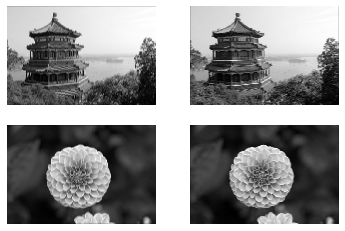

In [79]:
for image_index in (0,1):
    for feature_map_index in(0,1):
        plt.subplot(2,2,image_index*2 + feature_map_index+1)
        plot_image(outputs[image_index,:,:,feature_map_index])
plt.show()

In [80]:
def crop(images):
    return images[150:220, 130:250]

Saving figure china_original


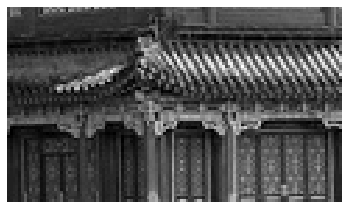

Saving figure China_vertical


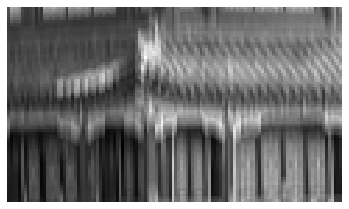

Saving figure China_horizintal


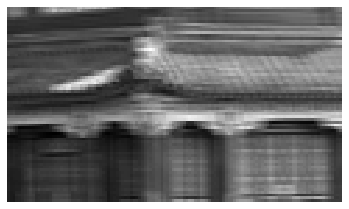

In [81]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()


for feature_map_index, filename in enumerate(["China_vertical","China_horizintal"]):
    plot_image(crop(outputs[0,:,:,feature_map_index]))
    save_fig(filename,tight_layout = False)
    plt.show()

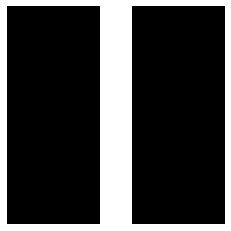

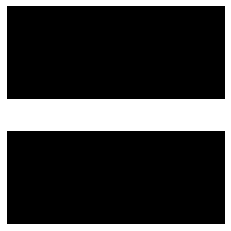

In [82]:
plot_image(filters[:,:,0,0])
plt.show()
plot_image(filters[:,:,0,1])
plt.show()

In [83]:
#using keras.layers.conv2D
conv = keras.layers.Conv2D(filters = 32,strides = 1, kernel_size = 3, padding = "same",activation = "relu")
#valid vs same padding
def feature_map_size(input_size,kernel_size,strides,padding = "same"):
    if padding == "same":
        return (input_size-1)//strides +1
    else:
        return (input_size-kernel_size)// strides +1

In [84]:
def pad_before_and_padded_size(input_size,kernel_size,strides=1):
    fmap_size = feature_map_size(input_size,kernel_size, strides)
    padded_size = max((fmap_size-1)*strides+kernel_size, input_size)
    pad_before = (padded_size-input_size)//2
    return pad_before,padded_size
    
    

In [85]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width  = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

In [86]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="VALID")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, strides=strides, padding="SAME")

valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Need to call build() so conv_same's weights get created
conv_same.build(tf.TensorShape(images.shape))

# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

assert np.allclose(valid_output.numpy(), same_output.numpy())

## pooling layer

In [87]:
#max pool
max_pool = keras.layers.MaxPool2D(pool_size = 2)

In [88]:
cropped_images = np.array([crop(image) for image in images],dtype = np.float32)
output = max_pool(cropped_images)

In [89]:
cropped_images[0]

array([[[0.26666668, 0.15294118, 0.17254902],
        [0.42745098, 0.3529412 , 0.3764706 ],
        [0.39607844, 0.38039216, 0.38431373],
        ...,
        [0.4862745 , 0.28235295, 0.2901961 ],
        [0.3529412 , 0.15686275, 0.16078432],
        [0.53333336, 0.32156864, 0.3137255 ]],

       [[0.2901961 , 0.1764706 , 0.19607843],
        [0.46666667, 0.39215687, 0.41568628],
        [0.38431373, 0.3647059 , 0.38039216],
        ...,
        [0.49019608, 0.2901961 , 0.28627452],
        [0.36862746, 0.20392157, 0.20784314],
        [0.4       , 0.21176471, 0.19607843]],

       [[0.24313726, 0.16078432, 0.15686275],
        [0.49803922, 0.43529412, 0.4392157 ],
        [0.4392157 , 0.4       , 0.40392157],
        ...,
        [0.47843137, 0.31764707, 0.30980393],
        [0.3647059 , 0.2       , 0.20392157],
        [0.36078432, 0.19607843, 0.2       ]],

       ...,

       [[0.12941177, 0.05098039, 0.05882353],
        [0.1254902 , 0.03529412, 0.05882353],
        [0.12941177, 0

Saving figure china_max_pooling


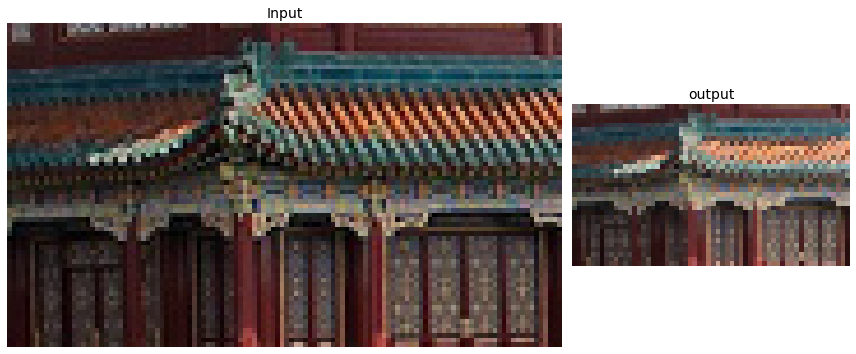

In [90]:
fig = plt.figure(figsize = (12,8))
gs = mpl.gridspec.GridSpec(nrows = 1,ncols = 2,width_ratios= [2,1])
ax1 = fig.add_subplot(gs[0,0])
ax1.set_title("Input",fontsize = 14)
ax1.imshow(cropped_images[0])
ax1.axis("off")
ax2 = fig.add_subplot(gs[0,1])
ax2.set_title("output",fontsize = 14)
ax2.imshow(output[0])
ax2.axis("off")
save_fig("china_max_pooling")
plt.show()

## depth wise pooling

In [91]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self,pool_size,strides= None , padding= "valid",**kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self,inputs):
        return tf.nn.max_pool(inputs,ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

## tackling fashion mnist witha cnn

In [92]:
(x_train_full,y_train_full),(x_test,y_test) = keras.datasets.fashion_mnist.load_data()
x_train,x_valid= x_train_full[:-5000],x_train_full[-5000:]
y_train,y_valid = y_train_full[:-5000],y_train_full[-5000:]

x_mean = x_train.mean(axis = 0,keepdims = True)
x_std = x_train.std(axis = 0,keepdims =  True) + 1e-7
x_train = (x_train - x_mean)/ x_std
x_valid = (x_valid- x_mean)/ x_std
x_test = (x_test- x_mean)/ x_std



In [93]:
x_train.shape

(55000, 28, 28)

In [94]:
x_train = x_train[..., np.newaxis]
x_valid = x_valid[..., np.newaxis]
x_test = x_test[..., np.newaxis]

In [24]:
from functools import partial

defaultconv2d = partial(keras.layers.Conv2D,kernel_size = 3, activation = "relu",padding = "same")
model = keras.models.Sequential([
    defaultconv2d(filters = 64,kernel_size = 7,input_shape = [28,28,1]),
    keras.layers.MaxPooling2D(pool_size = 2),
    defaultconv2d(filters = 128),
    defaultconv2d(filters = 128),
    keras.layers.MaxPooling2D(pool_size = 2),
    defaultconv2d(filters = 256),
    defaultconv2d(filters = 256),
    keras.layers.MaxPooling2D(pool_size = 2),
    keras.layers.Flatten(),
    keras.layers.Dense(units = 128,activation = "relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units = 64,activation = "relu"),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(units = 10, activation = "softmax"),
    
])


In [52]:
model.compile(loss = "sparse_categorical_crossentropy",optimizer = "nadam",metrics = ["accuracy"])
history = model.fit(x_train,y_train,epochs= 10,validation_data = (x_valid,y_valid))
score = model.evaluate(x_test,y_test)
x_new = x_test[:10]
y_pred = model.predict(x_new)
                    

Epoch 1/10


ValueError: in user code:

    c:\users\1042g\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    c:\users\1042g\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\1042g\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\1042g\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\1042g\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\1042g\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    c:\users\1042g\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    c:\users\1042g\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    c:\users\1042g\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\sequential.py:375 call
        return super(Sequential, self).call(inputs, training=training, mask=mask)
    c:\users\1042g\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\functional.py:424 call
        return self._run_internal_graph(
    c:\users\1042g\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    c:\users\1042g\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\users\1042g\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:219 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer max_pooling2d_9 is incompatible with the layer: expected ndim=4, found ndim=6. Full shape received: (None, 28, 28, 1, 1, 64)


In [62]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_valid, y_valid))
score = model.evaluate(x_test, y_test)
x_new =x_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 520s 301ms/step - loss: 0.8283 - accuracy: 0.7004 - val_loss: 0.3336 - val_accuracy: 0.8758
Epoch 2/10
1719/1719 [==============================] - 412s 240ms/step - loss: 0.3621 - accuracy: 0.8717 - val_loss: 0.2813 - val_accuracy: 0.8958
Epoch 3/10
1719/1719 [==============================] - 424s 247ms/step - loss: 0.3055 - accuracy: 0.8914 - val_loss: 0.2749 - val_accuracy: 0.8934
Epoch 4/10
1719/1719 [==============================] - 429s 250ms/step - loss: 0.2752 - accuracy: 0.9029 - val_loss: 0.2741 - val_accuracy: 0.8952
Epoch 5/10
1719/1719 [==============================] - 427s 248ms/step - loss: 0.2455 - accuracy: 0.9130 - val_loss: 0.2732 - val_accuracy: 0.9016
Epoch 6/10
1719/1719 [==============================] - 14062s 8s/step - loss: 0.2306 - accuracy: 0.9162 - val_loss: 0.2589 - val_accuracy: 0.9074
Epoch 7/10
1719/1719 [==============================] - 359s 209ms/step - loss: 0.2159 - accuracy: 0.9213 - val_l

NameError: name 'X_new' is not defined

In [63]:
y_pred = model.predict(x_new)

In [64]:
x_train.shape

(55000, 28, 28, 1)

## resnet 34

In [65]:
from functools import partial
defconv = partial(keras.layers.Conv2D,kernel_size=3, padding = "SAME",strides =1,use_bias = False)
class ResidualUnit(keras.layers.Layer):
    def __init__(self,filters,strides=1,activation = "relu",**kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            defconv(filters,strides = strides),
            keras.layers.BatchNormalization(),
            self.activation,
            defconv(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides >1:
            self.skip_layers = [
                defconv(filters,kernel_size =1,strides = strides),
                keras.layers.BatchNormalization()]
    def call (self,inputs):
        z = inputs
        for layer in self.main_layers:
            z =layer(z)
        skip_z = inputs
        for layer in self.skip_layers:
              skip_z = layer(skip_z)
        return self.activation(z +skip_z)
        

In [66]:
model = keras.models.Sequential()
model.add(defconv(64 , kernel_size = 7 , strides = 2, input_shape = [224,224,3] ))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size = 3, strides = 2,padding = "same"))
prev_filters =  64
for filters in [64]*3+ [128]*4+[256]*6 + [512]*3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters , strides = strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10,activation = "softmax"))

In [68]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_204 (Conv2D)          (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_201 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_9 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit_89 (ResidualUn (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_90 (ResidualUn (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_91 (ResidualUn (None, 56, 56, 64)      

## using a pretrained model

In [71]:
model = keras.applications.resnet50.ResNet50(weights= "imagenet")

102973440/102967424 [==============================] - 31s 0us/step


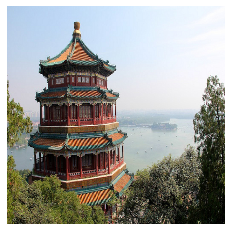

In [98]:
images_resized = tf.image.resize (images,[224,224])
plot_color_image(images_resized[0])
plt.show()
                 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


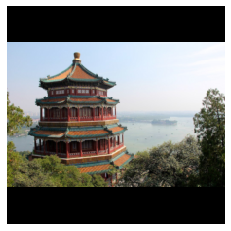

In [99]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

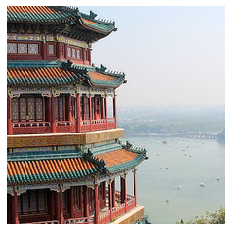

In [100]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

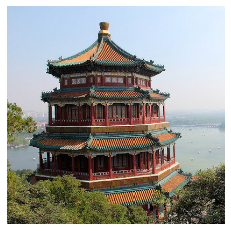

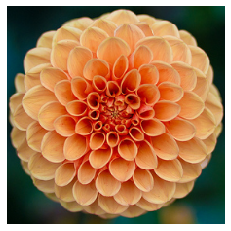

In [130]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

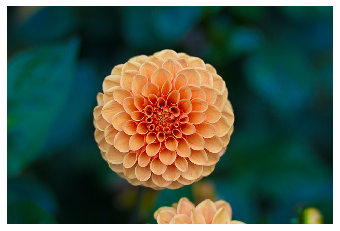

In [121]:
plot_color_image(images[1])
plt.show()

In [142]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
y_proba = model.predict(inputs)

In [143]:
y_proba.shape

(2, 1000)

In [144]:
top_k = keras.applications.resnet50.decode_predictions(y_proba , top =3)
for image_index  in range(len(images)):
    print("image#{}".format(image_index))
    for class_id, name, y_proba1 in top_k[image_index]:
        print("{} - {:12s} {:.2f}%".format(class_id,name,y_proba1*100))

image#0
n03877845 - palace       43.39%
n02825657 - bell_cote    43.08%
n03781244 - monastery    11.69%
image#1
n04522168 - vase         53.97%
n07930864 - cup          9.52%
n11939491 - daisy        4.96%


## pretrained model for transfer learning

In [2]:
import tensorflow_datasets as tfds
dataset, info = tfds.load("tf_flowers", as_supervised = True, with_info = True)

In [147]:
!pip install tensorflow_datasets

  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21502 sha256=142023d5db05ac1a7a7467ce1737e0a011dbaefb9f57fad313e79681a946aef7
  Stored in directory: c:\users\1042g\appdata\local\pip\cache\wheels\54\aa\01\724885182f93150035a2a91bce34a12877e8067a97baaf5dc8
Successfully built promise


In [3]:
info.splits

{'train': <SplitInfo num_examples=3670, num_shards=2>}

In [4]:

info.splits["train"]

<SplitInfo num_examples=3670, num_shards=2>

In [5]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [6]:
n_classes = info.features["label"].num_classes

In [7]:

dataset_size = info.splits["train"].num_examples
dataset_size

3670

In [33]:
train_set,test_set,valid_set = tfds.load("tf_flowers"
                                         , split = ["train[:75%]","train[75%:85%]", "train[85%:]"]
                                         ,as_supervised = True)

In [34]:
train_set

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

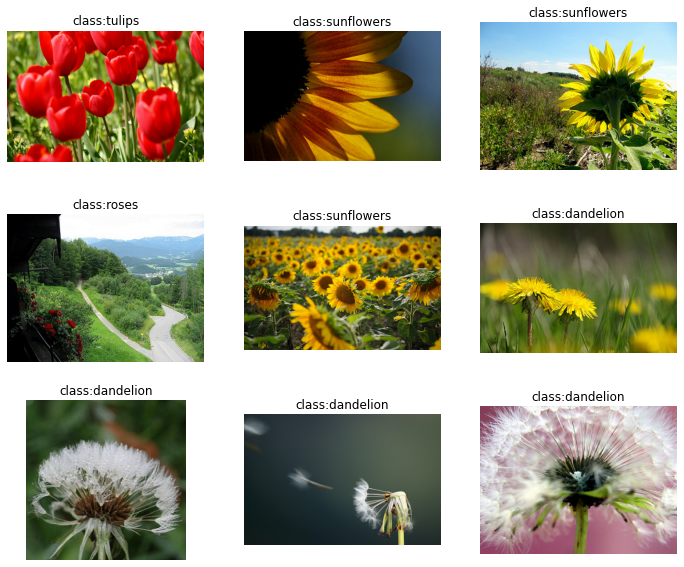

In [35]:
plt.figure(figsize = (12,10))
index = 0
for image,label in train_set.take(9):
    index +=1
    plt.subplot(3,3,index)
    plt.imshow(image)
    plt.title("class:{}".format(class_names[label]))
    plt.axis("off")

In [36]:
#basic prerpocessing
def preprocess(image,label):
    resized_image = tf.image.resize(image,[224,224])
    final_image = keras.applications.Xception.preprocess_input(resized_image)
    return final_image,label


In [37]:
from functools import partial
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0],shape[1]])
    top_crop = (shape [0]-min_dim)//4
    bottom_crop = shape[0]-top_crop
    left_crop = (shape[1]- min_dim)//4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]
def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0],shape[1]])* 90//100
    return tf.image.random_crop(image,[min_dim,min_dim,3])
def preprocess(image,label,randomize = False):
    if randomize :
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image,[224,224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image,label
batch_size = 32
train_set1 = train_set.shuffle(1000).repeat()
train_set2 = train_set1.map(partial(preprocess,randomize = True)).batch(batch_size).prefetch(1)
valid_set2 = valid_set.map(partial(preprocess)).batch(batch_size).prefetch(1)
test_set2 = test_set.map(partial(preprocess)).batch(batch_size).prefetch(1)  
    

<ipython-input-54-2890ce4c214b>:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(3,3,index+1)


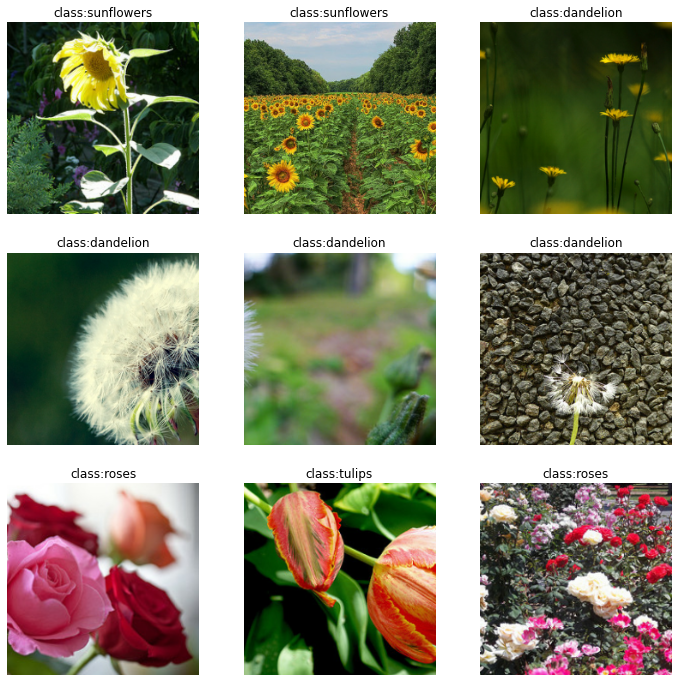

In [54]:
plt.figure(figsize = (12,12))
for x_batch,y_batch in train_set2.take(9):
    for index in range(9):
        plt.subplot(3,3,index+1)
        plt.imshow(x_batch[index]/2 +0.5)
        plt.title("class:{}".format(class_names[y_batch[index]]))
        plt.axis("off")
plt.show()    

In [56]:
base_model = keras.applications.xception.Xception(weights = "imagenet",include_top = False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes,activation = "softmax")(avg)
model1 = keras.models.Model(inputs = base_model.input,outputs = output)

83689472/83683744 [==============================] - 19s 0us/step


In [57]:
for index,layer in enumerate(base_model.layers):
    print(index,layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d
13 block2_pool
14 batch_normalization
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_1
23 block3_pool
24 batch_normalization_1
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_2
33 block4_pool
34 batch_normalization_2
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepconv3_act

In [62]:
for layer in base_model.layers:
    layer.trainable = False
optimizer = keras.optimizers.SGD(lr = 0.2,momentum = 0.9, decay = 0.01 )
model1.compile(loss = "sparse_categorical_crossentropy",optimizer = optimizer,metrics = ["accuracy"])
history = model1.fit(train_set2,steps_per_epoch= int(0.75* dataset_size/batch_size),
                   validation_data = valid_set,validation_steps = int(0.15* dataset_size/batch_size),
                   epochs = 1)

86/86 [==============================] - ETA: 0s - loss: 0.6142 - accuracy: 0.8808WARNING:tensorflow:Model was constructed with shape (None, None, None, 3) for input KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (None, None, 3).


ValueError: in user code:

    c:\users\1042g\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1233 test_function  *
        return step_function(self, iterator)
    c:\users\1042g\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1224 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\users\1042g\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\users\1042g\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\users\1042g\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\users\1042g\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1217 run_step  **
        outputs = model.test_step(data)
    c:\users\1042g\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\training.py:1183 test_step
        y_pred = self(x, training=False)
    c:\users\1042g\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:1012 __call__
        outputs = call_fn(inputs, *args, **kwargs)
    c:\users\1042g\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\functional.py:424 call
        return self._run_internal_graph(
    c:\users\1042g\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\functional.py:560 _run_internal_graph
        outputs = node.layer(*args, **kwargs)
    c:\users\1042g\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    c:\users\1042g\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:234 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer block1_conv1 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (None, None, 3)


In [ ]:

for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=1)

## classification and localization

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
base_model = keras.applications.xception.Xception(weights = "imagenet",include_top = False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes,activation = "softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(input = base_model.input, output = [class_output,loc_output])
model.compile(loss = ["sparse_catgorical_crossentropy","mse"],loss_weights = [0.8,0.2],optimizer = optimizer, metrcis = ["accuracy"])

In [ ]:
def add_random_bounding_boxes(images,labels):
    fake_boxed = tf.random.uniform([tf.shape(images)[0],4])
fake_train_set = tain_set.take(5).reapeat(2),map(add_random_bounding_boxes)

In [ ]:
model.fit(fake_train_set,steps_per_epoch= 5, epochs = 2)

## mean average precision

In [24]:
 def maximum_precisions(pecisions):
        return  np.flip(np.maximum.accumulate(np.flip(precisions)))


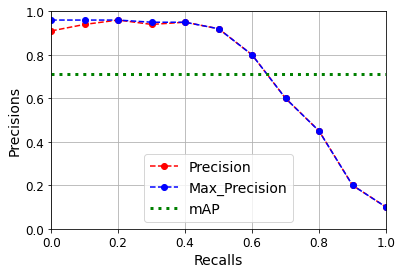

In [26]:
recalls = np.linspace(0,1,11)
precisions = [0.91,0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls,precisions,"ro--",label = "Precision")
plt.plot(recalls,max_precisions,"bo--",label = "Max_Precision")
plt.xlabel("Recalls")
plt.ylabel("Precisions")
plt.plot([0,1],[mAP,mAP], "g:", linewidth = 3, label = "mAP")
plt.grid(True)
plt.axis([0,1,0,1])
plt.legend(loc = "lower center", fontsize = 14)
plt.show()

In [23]:
max_precisions

array([0.1 , 0.2 , 0.45, 0.6 , 0.8 , 0.92, 0.95, 0.95, 0.96, 0.96, 0.96])

## transpose convolutions

In [27]:
tf.random.set_seed(42)
x = images_resized.numpy()
conv_transpose = keras.layersConv2DTranspose(filters =5,kernel_size = 3,strides = 2,paddinf = "valid")
output = conv_transpose(x)
output.shape

NameError: name 'images_resized' is not defined

In [ ]:
def normalize(x):
    return (x -tf.reduce_min(x))/ (tf.reduce_max(x)- tf.reduce_min(x))
fig  = plt.figure(figsize =(12,8) )
gs = mpl.gridspec.Gridspec(nrows = 1,ncols=2,width_ratios= [1,2])
ax1 = fig.add_subplot(gs[0,0])
ax1.set_title("input",fontsize = 14)
ax1.imshow(x[0])
ax1.axis("off")
ax1 = fig.add_subplot(gs[0,1])
ax1.set_title("output",fontsize = 14)
ax1.imshow(normalize(output[0,...,:3]),interpolation = "bicubic")
ax1.axis("off")
plt.show()



In [ ]:
def upscale_images(images,stride,kernel_size):
    batch_size, height,width,channels = images.shape
    upscaled = np.zeros((batch_size,
                        (height-1)*(stride+2)*kernel_size-1,
                        (width-1)*(stride+2)*kernel_size -1,
                        channels
                       ))
       upscaled[:,
             kernel_size - 1:(height - 1) * stride + kernel_size:stride,
             kernel_size - 1:(width - 1) * stride + kernel_size:stride,
             :] = images
    return upscaled